In [1]:
import os
import sys
import types
from pathlib import Path
from types import SimpleNamespace

from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import matplotlib.pyplot as plt


In [2]:
PATCH_ROOT = Path(
    r"C:\Users\Kdbro\OneDrive\Desktop\OSU\Fall 2025\Neural Networks\Contrastive-and-Attribute-Aligned-Representation-Learning-for-Animal-Footprint\dataset\footprint_patches"
)

# Encoder checkpoint 
ENCODER_CKPT = "footprint_encoder_contrastive.pth"

image_size = 128
feature_dim = 256
batch_size = 64
num_epochs = 20
learning_rate = 1e-3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [3]:
class FootprintPatchDataset(Dataset):
    """
    Classification-style dataset for cropped footprint patches.
    Assumes directory structure:
      root_dir/
        class_name0/
          *.jpg
        class_name1/
          *.jpg
        ...
    """
    def __init__(self, root_dir, transform=None):
        self.root_dir = Path(root_dir)
        self.transform = transform

        self.image_paths = []
        self.labels = []
        self.class_to_idx = {}
        self.idx_to_class = []

        for class_idx, class_name in enumerate(sorted(os.listdir(self.root_dir))):
            class_path = self.root_dir / class_name
            if not class_path.is_dir():
                continue

            self.class_to_idx[class_name] = class_idx
            self.idx_to_class.append(class_name)

            for fname in os.listdir(class_path):
                if fname.lower().endswith((".jpg", ".jpeg", ".png")):
                    self.image_paths.append(class_path / fname)
                    self.labels.append(class_idx)

        print(f"Loaded {len(self.image_paths)} images "
              f"from {self.root_dir}, {len(self.idx_to_class)} classes.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label


In [4]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(image_size, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor(),
])

eval_transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
])

train_dataset = FootprintPatchDataset(
    PATCH_ROOT / "train",
    transform=train_transform
)

val_dataset = FootprintPatchDataset(
    PATCH_ROOT / "valid",
    transform=eval_transform
)

num_classes = len(train_dataset.idx_to_class)
print("Number of classes:", num_classes)

train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=0
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=0
)


Loaded 12575 images from C:\Users\Kdbro\OneDrive\Desktop\OSU\Fall 2025\Neural Networks\Contrastive-and-Attribute-Aligned-Representation-Learning-for-Animal-Footprint\dataset\footprint_patches\train, 117 classes.
Loaded 1882 images from C:\Users\Kdbro\OneDrive\Desktop\OSU\Fall 2025\Neural Networks\Contrastive-and-Attribute-Aligned-Representation-Learning-for-Animal-Footprint\dataset\footprint_patches\valid, 117 classes.
Number of classes: 117


In [5]:
class FootprintEncoder(nn.Module):
    """
    Simple CNN encoder for footprint images.
    Input: (B, 3, 128, 128)
    Output: (B, feature_dim)
    """
    def __init__(self, feature_dim=256):
        super().__init__()
        self.feature_dim = feature_dim

        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 128 -> 64
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 64 -> 32
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2)  # 32 -> 16
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.AdaptiveAvgPool2d((1, 1))
        )

        self.fc = nn.Linear(256, feature_dim)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


In [6]:
feature_dim = 256  # whatever used in contrastive training
ENCODER_CKPT = "footprint_encoder_contrastive.pth"  

encoder = FootprintEncoder(feature_dim=feature_dim)

if 'torch.utils.serialization' not in sys.modules:
    ser_mod = types.ModuleType('torch.utils.serialization')
else:
    ser_mod = sys.modules['torch.utils.serialization']

if not hasattr(ser_mod, 'config'):
    ser_mod.config = SimpleNamespace(
        save=SimpleNamespace(
            compute_crc32=True,
            use_pinned_memory_for_d2h=False,
            storage_alignment=64,
        ),
        load=SimpleNamespace(
            mmap=False,
            endianness=getattr(
                torch.serialization,
                "LoadEndianness",
                None
            ),
            mmap_flags=None,
            calculate_storage_offsets=False,
        ),
    )

sys.modules['torch.utils.serialization'] = ser_mod

# load the weights
state_dict = torch.load(ENCODER_CKPT, map_location=device)
encoder.load_state_dict(state_dict)

# Freeze encoder params
for p in encoder.parameters():
    p.requires_grad = False

encoder = encoder.to(device)
encoder.eval()

print("Encoder loaded and frozen on", device)



Encoder loaded and frozen on cpu


In [7]:
class LinearProbe(nn.Module):
    def __init__(self, encoder, feature_dim=256, num_classes=10):
        super().__init__()
        self.encoder = encoder
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        with torch.no_grad():
            features = self.encoder(x)   # (B, feature_dim)
        logits = self.fc(features)       # (B, num_classes)
        return logits

model = LinearProbe(
    encoder=encoder,
    feature_dim=feature_dim,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.fc.parameters(),  # ONLY train classifier head
    lr=learning_rate,
    weight_decay=1e-4
)

model


LinearProbe(
  (encoder): FootprintEncoder(
    (conv1): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv2): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv3): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (conv4

In [9]:
from tqdm.auto import tqdm

def compute_features(encoder, dataloader, device):
    encoder.eval()
    all_feats = []
    all_labels = []
    
    print("Computing features...")
    with torch.no_grad():
        for images, labels in tqdm(dataloader, total=len(dataloader)):
            images = images.to(device)
            feats = encoder(images)          # (B, feature_dim)
            all_feats.append(feats.cpu())    # keep on CPU
            all_labels.append(labels.cpu())

    all_feats = torch.cat(all_feats, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    return all_feats, all_labels

train_feats, train_labels = compute_features(encoder, train_loader, device)
val_feats, val_labels = compute_features(encoder, val_loader, device)

print("Train features:", train_feats.shape)
print("Val features:", val_feats.shape)


Computing features...


100%|██████████| 197/197 [01:39<00:00,  1.97it/s]


Computing features...


100%|██████████| 30/30 [00:27<00:00,  1.08it/s]

Train features: torch.Size([12575, 256])
Val features: torch.Size([1882, 256])


In [10]:
class FeatureDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return self.features.size(0)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_feat_dataset = FeatureDataset(train_feats, train_labels)
val_feat_dataset = FeatureDataset(val_feats, val_labels)

feat_batch_size = 256 

train_feat_loader = DataLoader(
    train_feat_dataset,
    batch_size=feat_batch_size,
    shuffle=True,
    num_workers=0,
)

val_feat_loader = DataLoader(
    val_feat_dataset,
    batch_size=feat_batch_size,
    shuffle=False,
    num_workers=0,
)

In [11]:
class LinearClassifier(nn.Module):
    def __init__(self, feature_dim, num_classes):
        super().__init__()
        self.fc = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.fc(x)


In [12]:
num_classes = len(train_dataset.idx_to_class)  # or however you computed this

model = LinearClassifier(
    feature_dim=feature_dim,
    num_classes=num_classes
).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
    weight_decay=1e-4
)

print(model)


LinearClassifier(
  (fc): Linear(in_features=256, out_features=117, bias=True)
)


In [13]:
def evaluate(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for feats, labels in dataloader:
            feats = feats.to(device)
            labels = labels.to(device)

            outputs = model(feats)
            preds = outputs.argmax(dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    acc = correct / total if total > 0 else 0.0
    return acc


In [14]:
def train_linear_probe(model, train_loader, val_loader, optimizer,
                       criterion, device, num_epochs=10):
    train_acc_history = []
    val_acc_history = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        print(f"\n=== Epoch {epoch+1}/{num_epochs} ===")

        for batch_idx, (feats, labels) in enumerate(train_loader):
            feats = feats.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(feats)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            preds = outputs.argmax(dim=1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

            if (batch_idx + 1) % 20 == 0 or (batch_idx + 1) == len(train_loader):
                current_loss = running_loss / total
                current_acc = correct / total if total > 0 else 0.0
                print(
                    f"  [Batch {batch_idx+1}/{len(train_loader)}] "
                    f"loss={current_loss:.4f}, acc={current_acc*100:.2f}%"
                )

        train_loss = running_loss / total if total > 0 else 0.0
        train_acc = correct / total if total > 0 else 0.0
        val_acc = evaluate(model, val_loader, device)

        train_acc_history.append(train_acc)
        val_acc_history.append(val_acc)

        print(
            f"Epoch {epoch+1} summary: "
            f"train_loss={train_loss:.4f}, "
            f"train_acc={train_acc*100:.2f}%, "
            f"val_acc={val_acc*100:.2f}%"
        )

    return train_acc_history, val_acc_history



=== Epoch 1/20 ===
  [Batch 20/50] loss=4.6725, acc=3.50%
  [Batch 40/50] loss=4.5821, acc=5.80%
  [Batch 50/50] loss=4.5487, acc=6.42%
Epoch 1 summary: train_loss=4.5487, train_acc=6.42%, val_acc=8.34%

=== Epoch 2/20 ===
  [Batch 20/50] loss=4.2927, acc=9.59%
  [Batch 40/50] loss=4.2555, acc=9.51%
  [Batch 50/50] loss=4.2389, acc=9.65%
Epoch 2 summary: train_loss=4.2389, train_acc=9.65%, val_acc=8.77%

=== Epoch 3/20 ===
  [Batch 20/50] loss=4.1134, acc=10.02%
  [Batch 40/50] loss=4.0907, acc=10.35%
  [Batch 50/50] loss=4.0824, acc=10.43%
Epoch 3 summary: train_loss=4.0824, train_acc=10.43%, val_acc=9.78%

=== Epoch 4/20 ===
  [Batch 20/50] loss=4.0102, acc=10.84%
  [Batch 40/50] loss=3.9937, acc=10.62%
  [Batch 50/50] loss=3.9888, acc=10.82%
Epoch 4 summary: train_loss=3.9888, train_acc=10.82%, val_acc=9.83%

=== Epoch 5/20 ===
  [Batch 20/50] loss=3.9369, acc=11.37%
  [Batch 40/50] loss=3.9241, acc=11.44%
  [Batch 50/50] loss=3.9263, acc=11.27%
Epoch 5 summary: train_loss=3.9263, 

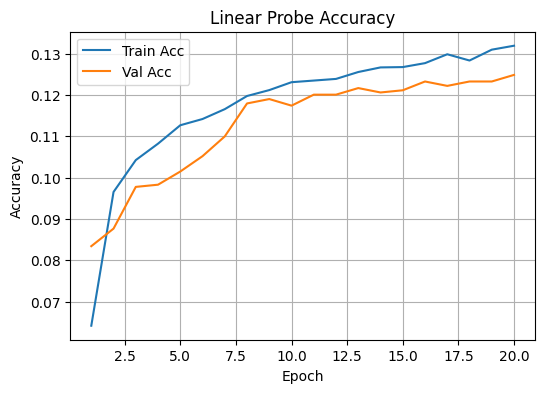

In [15]:
num_epochs = 20  # or whatever you like

train_acc_hist, val_acc_hist = train_linear_probe(
    model,
    train_feat_loader,
    val_feat_loader,
    optimizer,
    criterion,
    device,
    num_epochs=num_epochs
)


epochs = range(1, num_epochs + 1)

plt.figure(figsize=(6, 4))
plt.plot(epochs, train_acc_hist, label="Train Acc")
plt.plot(epochs, val_acc_hist, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Linear Probe Accuracy")
plt.legend()
plt.grid(True)
plt.show()